In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/PhD/codes/pips/

/content/drive/MyDrive/PhD/codes/pips


In [7]:
!python --version

Python 3.10.11


In [3]:

pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.5/120.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.4/30.4 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115927 sha256=c99c9eabe1141816628ffc123242b778a01976707d0187b92d45e97b6a86e9e0
  Stored in directory: /root/.cache/pip/wheels/26/9a/dd/2818b1b023daf077ec3e625c47ae446aca587a5abe48e05212
Successfully built fire
  Attempting un

In [ ]:
pip install imageio[pyav]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import time
import numpy as np
import io
import os
import torch.nn.functional as F

import torch
from PIL import Image
import cv2
import saverloader
from nets.pips import Pips
import imageio.v3 as imageio
from demo import run_model
import utils.improc
import random
import glob
from utils.basic import print_, print_stats
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import pandas as pd
import ast

In [ ]:
# segment anything

    
import torchvision
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
!mkdir images

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-il1zawfi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-il1zawfi
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
mkdir: cannot create directory ‘images’: File exists
--2023-05-09 19:13:50--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTT

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = 'cpu'#"cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)
predictor = SamPredictor(sam)
#predictor.set_image(image)


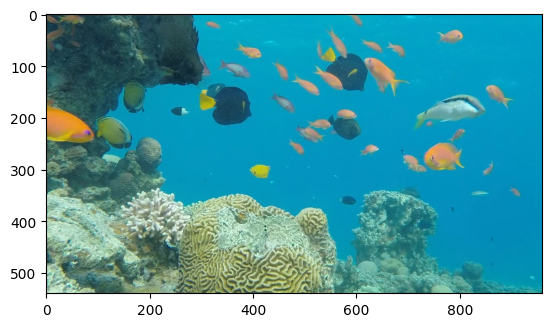

In [ ]:
image_path = '/content/drive/MyDrive/PhD/Side projects and assists/Sagi/sample_frame.jpg'
image = imageio.imread(image_path)
plt.imshow(image)

In [ ]:
masks = mask_generator.generate(image)

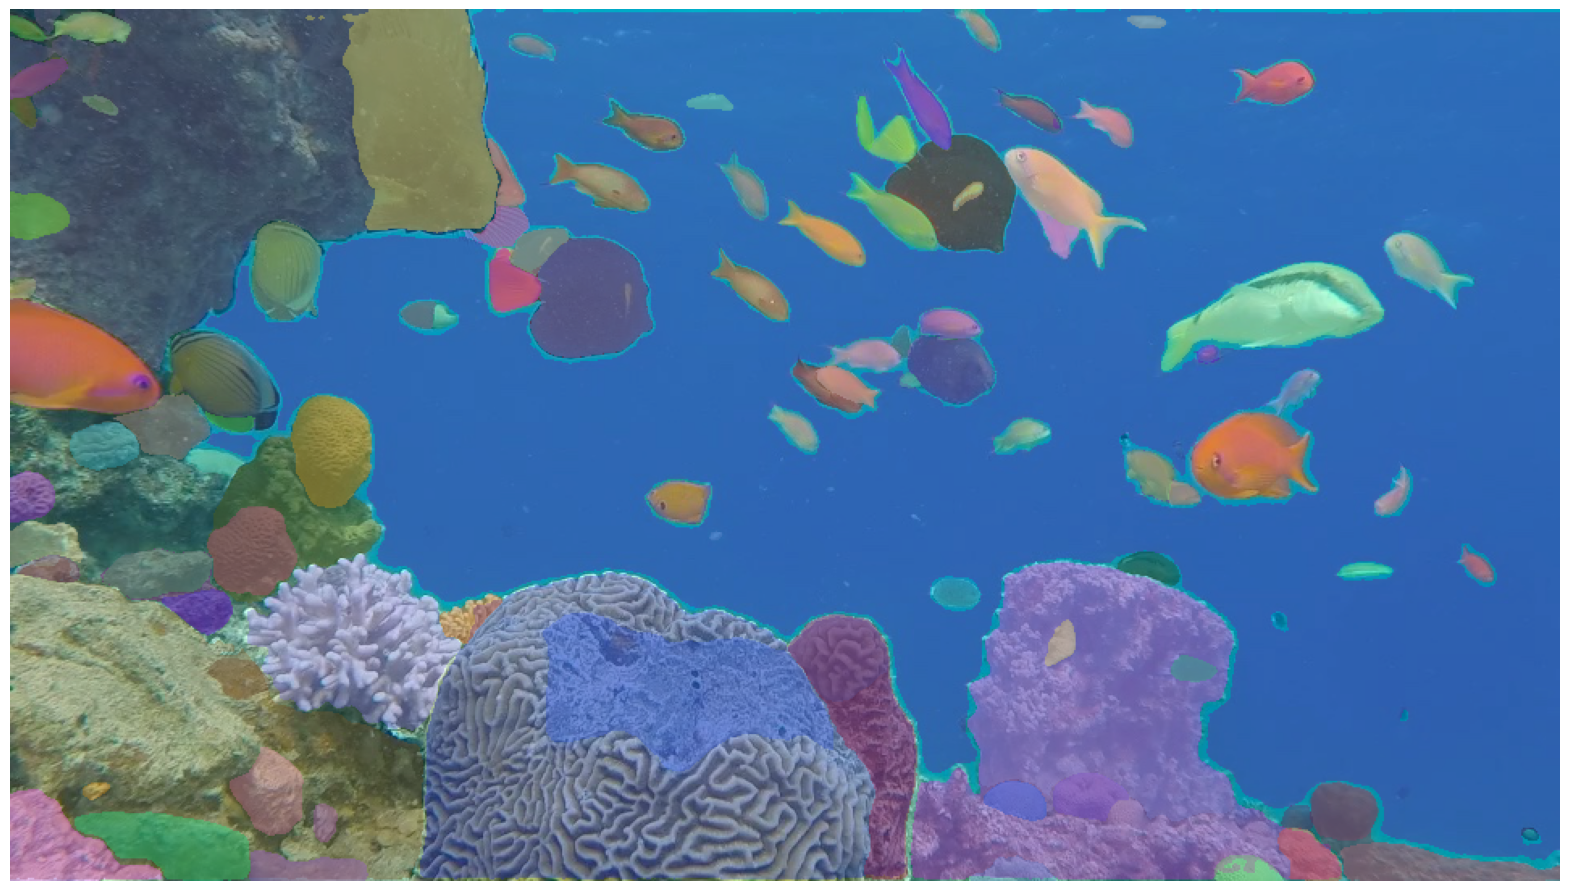

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=10,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)


In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [ ]:

vid=imageio.imread('/content/drive/MyDrive/PhD/codes/pips/feeding.avi',plugin='pyav')

In [ ]:
vid.shape

(41, 400, 400, 3)

In [ ]:
image = vid[0,...]
predictor.set_image(image)
masks = mask_generator.generate(image)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [ ]:


input_point = np.array([[200, 200]])
input_label = np.array([1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [ ]:
masks.shape 

(3, 400, 400)

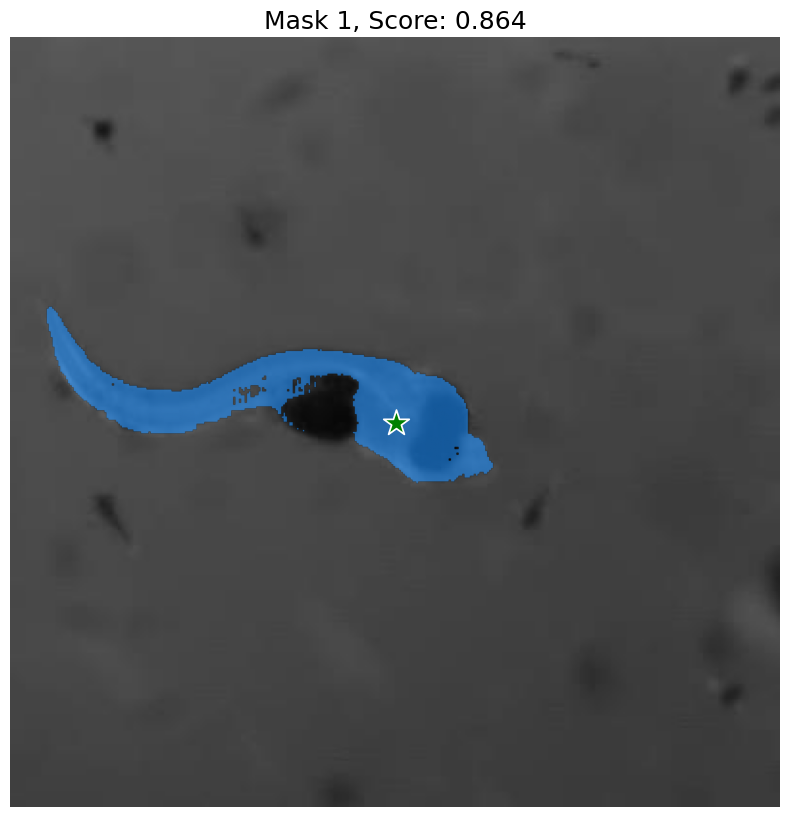

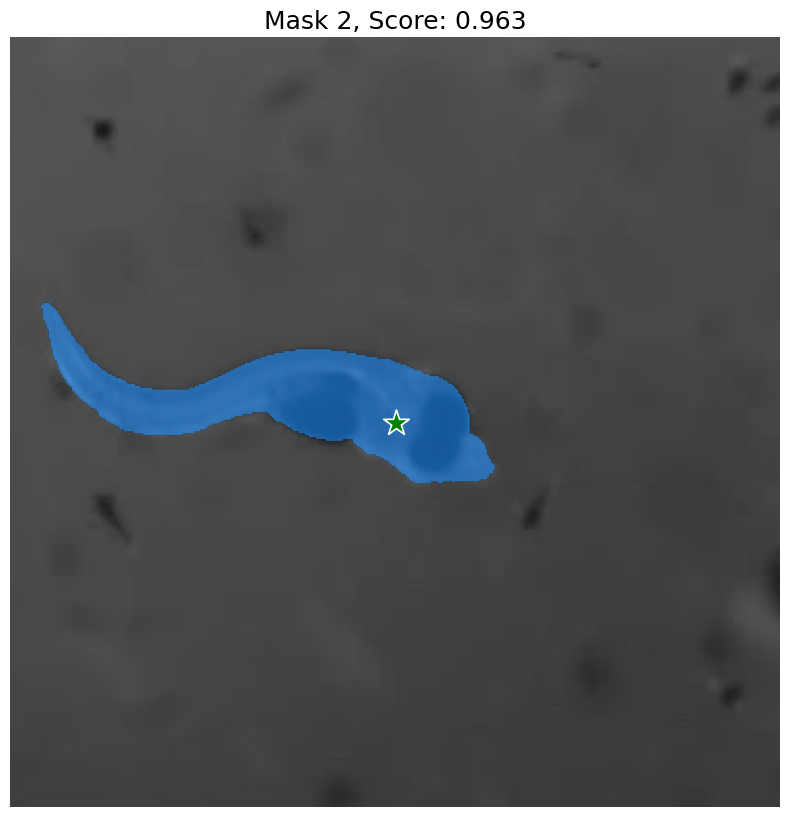

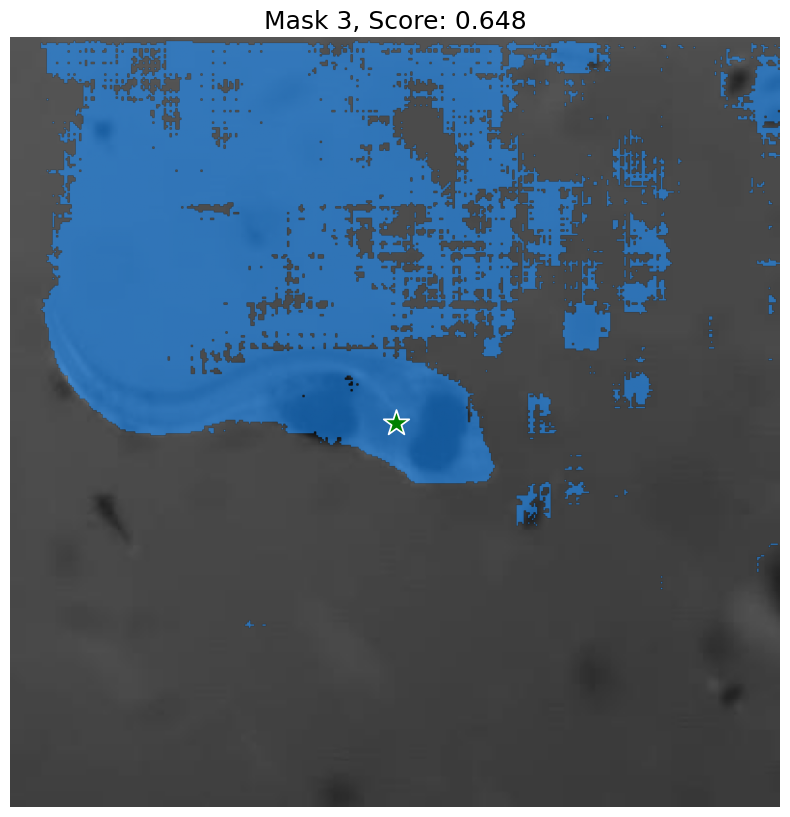

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

In [ ]:
mask= masks[1,...]

In [ ]:
t[0,fish_points,:]

array([[ 42, 182],
       [112, 182],
       [147, 182],
       [182, 182],
       [217, 182],
       [217, 217]])

In [ ]:
vid = get_vid('/content/drive/MyDrive/PhD/codes/pips/feeding.avi')
rgbs,trajs= run_model_custom(model,vid,N)
t = np.squeeze(trajs.cpu().numpy().astype(int))-50
t.clip(0,400)
fish_points = mask[t[0,:,1].clip(0,399),t[0,:,0].clip(0,399)]
t[:,fish_points,:].shape

trajs_e (float32) min = 6.74, mean = 203.02, max = 394.05 torch.Size([1, 8, 144, 2])


(8, 6, 2)

In [ ]:
save_viz(rgbs,trajs[:,:,fish_points,...],'feeding_justfish',savedir='/content/drive/MyDrive/PhD/codes/pips/')


saved /content/drive/MyDrive/PhD/codes/pips/feeding_justfish.gif


In [ ]:
filename = 'Seq2_20DPH_F13 - frames 330763-330802-0-cropped.avi'
datadir = '/content/drive/MyDrive/PhD/Datasets/balanced_ds/train/strike'
outputs_dir = '/content/drive/MyDrive/PhD/Fishbase/larvae_flowfields/'

vid=imageio.imread(os.path.join(datadir,filename),plugin='pyav')
image = vid[0,...]
predictor.set_image(image)
_,vid = get_vid(os.path.join(datadir,filename))
plt.imshow(image)


RuntimeError: ignored

In [ ]:

input_point = np.array([[230, 270]])
input_label = np.array([1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

In [ ]:
mask= masks[2,...]
rgbs,trajs= run_model_custom(model,vid,N)
t = np.squeeze(trajs.cpu().numpy().astype(int))-50
t.clip(0,400)
fish_points = mask[t[0,:,1].clip(0,399),t[0,:,0].clip(0,399)]
print(t[:,fish_points,:].shape)
save_viz(rgbs,trajs[:,:,fish_points,...],'Seq2_20DPH_F13 - frames 330763-330802-0-cropped',savedir=outputs_dir)#'Seq2_30DPH_F15 - frames 180796-182501-1-cropped'


NameError: ignored

In [ ]:
fish_points

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,

In [ ]:
tens_vid = torch.from_numpy(vid).permute(0,3,1,2)
tens_vid = tens_vid.unsqueeze(dim=0)
tens_vid.shape

torch.Size([1, 41, 3, 400, 400])

In [ ]:
#select 8 frames uniformly from the video
num_frames = tens_vid.shape[1]
steps = num_frames//8
list(range(num_frames))[0:num_frames:steps]

[0, 5, 10, 15, 20, 25, 30, 35, 40]

In [ ]:
vid=imageio.imread(os.path.join(datadir,filename),plugin='pyav')
vid.shape

(35, 450, 450, 3)

In [ ]:
model = Pips(stride=4)#.cuda()
init_dir = 'reference_model'
_ = saverloader.load(init_dir, model)
model.eval()

reading ckpt from reference_model
...found checkpoint reference_model/model-000200000.pth


Pips(
  (fnet): BasicEncoder(
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (norm2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      

In [ ]:
#set hyperparameters and create the summary writer the code likes
B = 1 #batch size
S = 8 # num frames
N = 12**2 # num points to sample in the grid
log_freq = 2
global_step = 0
log_dir = './logs_demo'
model_name = 'Pips_checkpoint'
writer_t = SummaryWriter(log_dir + '/' + model_name + '/t', max_queue=10, flush_secs=60)

sw_t = utils.improc.Summ_writer(
    writer=writer_t,
    global_step=global_step,
    log_freq=log_freq,
    fps=5,
    scalar_freq=int(log_freq/2),
    just_gif=True)

In [ ]:
def run_model_custom(model, rgbs, N, mask=None):
#rgbs = tens_vid[:,0:40:5,...].cuda().float()
  B, S, C, H, W = rgbs.shape
  N_ = np.sqrt(N).round().astype(np.int32)
  grid_y, grid_x = utils.basic.meshgrid2d(B, N_, N_, stack=False, norm=False, device='cuda')
  grid_y = 8 + grid_y.reshape(B, -1)/float(N_-1) * (H-16)
  grid_x = 8 + grid_x.reshape(B, -1)/float(N_-1) * (W-16)
  xy = torch.stack([grid_x, grid_y], dim=-1) # B, N_*N_, 2
  _, S, C, H, W = rgbs.shape
  with torch.no_grad():
    preds, preds_anim, vis_e, stats = model(xy, rgbs, iters=6)
  trajs_e = preds[-1]
  print_stats('trajs_e', trajs_e)

  pad = 50
  rgbs = F.pad(rgbs.reshape(B*S, 3, H, W), (pad, pad, pad, pad), 'constant', 0).reshape(B, S, 3, H+pad*2, W+pad*2)
  trajs_e = trajs_e + pad
  return rgbs, trajs_e

In [ ]:
def save_viz(rgbs, trajs_e,filename,savedir='.'):
  linewidth=2
  o1 = sw_t.summ_rgbs('inputs/rgbs', utils.improc.preprocess_color(rgbs[0:1]).unbind(1))
  o2 = sw_t.summ_traj2ds_on_rgbs('outputs/trajs_on_rgbs', trajs_e[0:1], 
                                 utils.improc.preprocess_color(rgbs[0:1]), 
                                 cmap='spring', linewidth=linewidth)
  o3 = sw_t.summ_traj2ds_on_rgbs('outputs/trajs_on_black', 
                                 trajs_e[0:1], torch.ones_like(rgbs[0:1])*-0.5, 
                                 cmap='spring', linewidth=linewidth)
  wide_cat = torch.cat([o1, o2, o3], dim=-1)
  sw_t.summ_rgbs('outputs/wide_cat', wide_cat.unbind(1))
  wide_list = list(wide_cat.unbind(1))
  wide_list = [wide[0].permute(1,2,0).cpu().numpy() for wide in wide_list]
  wide_list = [Image.fromarray(wide) for wide in wide_list]
  out_fn = os.path.join(savedir,f'{filename}.gif')
  wide_list[0].save(out_fn, save_all=True, append_images=wide_list[1:])
  print('saved %s' % out_fn)

In [ ]:
def get_vid(vidpath, num_to_sample=8, center_vid=False):
  vid=imageio.imread(vidpath,plugin='pyav')
  tens_vid = torch.from_numpy(vid).permute(0,3,1,2)
  tens_vid = tens_vid.unsqueeze(dim=0)
  num_frames = tens_vid.shape[1]
  indices=np.linspace(0,num_frames-1,num=num_to_sample).astype(int)
  if center_vid:
    indices[int(num_to_sample/2)-1] = int(vid.shape[0]/2)-1
  return vid, tens_vid[:,indices,...].cuda().float()

In [ ]:
mask

NameError: ignored

torch.Size([1, 8, 3, 500, 500])

In [ ]:
#list(range(78))
vid = get_vid('/content/drive/MyDrive/PhD/codes/pips/feeding.avi')
rgbs,trajs= run_model_custom(model,vid,N)


trajs_e (float32) min = 6.74, mean = 203.02, max = 394.05 torch.Size([1, 8, 144, 2])


In [ ]:
xy.shape

torch.Size([1, 144, 2])

In [ ]:
trajs[0,0,...].shape

torch.Size([144, 2])

In [ ]:
partitions = ['train','val','test']
actions = ['swim','strike']
dataset = 'balanced_ds'
datadir = '/content/drive/MyDrive/PhD/Datasets/balanced_ds/train/swim'
outputs_dir = '/content/drive/MyDrive/PhD/Fishbase/larvae_flowfields/balanced_ds/train/swim'
os.makedirs(outputs_dir,exist_ok=True)
N=16**2
for partition in partitions:
  for action in actions:
    datadir = f'/content/drive/MyDrive/PhD/Datasets/{dataset}/{partition}/{action}'
    outputs_dir = f'/content/drive/MyDrive/PhD/Fishbase/larvae_flowfields/{dataset}_{np.sqrt(N)}x{np.sqrt(N)}/{partition}/{action}'
    os.makedirs(outputs_dir,exist_ok=True)
    vidnames = os.listdir(datadir)
    for vidname in vidnames:
      _,curr_vid = get_vid(os.path.join(datadir,vidname))
      rgbs,trajs = run_model_custom(model,curr_vid,N)
      torch.save({'vid_name':vidname,
                  'dataset':dataset,
                  'partition':partition,
                  'action_class':action,
                  'num_points_tracked':N,
                  'trajectories':trajs},os.path.join(outputs_dir,f'{vidname.strip(".avi")}_trajectories.pt'))
      save_viz(rgbs,trajs,vidname.split('.')[0],savedir=outputs_dir)

In [ ]:
# Now let's try with the naturalistic ds
# we'll use the bounding boxes from the detector as a prompt for SAM
# let's load the table with the bbox data:
naturalistic_data = pd.read_csv('/content/drive/MyDrive/PhD/Datasets/all_labels.csv')
# convert bboxes from str to list:
naturalistic_data.bboxs =  naturalistic_data.bboxs.map(lambda x: [float(num) for num in x.strip('[]').split(' ') if str.isnumeric(num.split('.')[0])])
naturalistic_data.centroid =  naturalistic_data.centroid.map(lambda x: [int(c) for c in x.split(' ') if str.isnumeric(c)])
print(naturalistic_data.bboxs.map(lambda x: len(x)==4).sum()) # check we didn't mess up
naturalistic_data.bboxs.isna().sum(),len(naturalistic_data)


4563


(0, 4563)

In [ ]:
# models:
# pips:
model = Pips(stride=4).cuda()
init_dir = 'reference_model'
_ = saverloader.load(init_dir, model)
model.eval()

log_freq = 2
global_step = 0
log_dir = './logs_demo'
model_name = 'Pips_checkpoint'
writer_t = SummaryWriter(log_dir + '/' + model_name + '/t', max_queue=10, flush_secs=60)

sw_t = utils.improc.Summ_writer(
    writer=writer_t,
    global_step=global_step,
    log_freq=log_freq,
    fps=5,
    scalar_freq=int(log_freq/2),
    just_gif=True)
# sam:
predictor = SamPredictor(sam)

reading ckpt from reference_model
...found checkpoint reference_model/model-000200000.pth


In [ ]:
#ds_path = '/content/drive/MyDrive/PhD/Datasets/naturalistic_ds'
dataset = 'naturalistic_ds'
partition = 'test'
action_classes = ['swim','strike']
N = 14**2
for action in action_classes:
  datadir = f'/content/drive/MyDrive/PhD/Datasets/{dataset}/{partition}/{action}'
  outputs_dir = f'/content/drive/MyDrive/PhD/Fishbase/larvae_flowfields/{dataset}_{np.sqrt(N)}x{np.sqrt(N)}/{partition}/{action}'
  os.makedirs(outputs_dir,exist_ok=True)
  vidnames = [f for f in os.listdir(datadir) if f.endswith('.avi')]
  for vidname in vidnames:
    assert len(naturalistic_data[naturalistic_data.clip_name==vidname])==1
    raw_vid,tens_vid = get_vid(os.path.join(datadir,vidname),center_vid=True)
    # get point trajectories
    rgbs,trajs = run_model_custom(model,tens_vid,N)
    # set image for the sam predictor
    image = raw_vid[int(len(raw_vid)/2)-1,...] # get midframe cause that where the bounding box is correct
    predictor.set_image(image)
    # get bounding box and centroid from data:
    input_box = np.array(naturalistic_data[naturalistic_data.clip_name==vidname].bboxs.item())
    centroid = naturalistic_data[naturalistic_data.clip_name==vidname].centroid.item()
    # the input box and centroid are in the whole frame axis system, we need to translate the coordinates to the clip axis:
    x_offset,_,y_offset,_ = get_clip_bounds([1080,1920], centroid, round(raw_vid.shape[-2]/2))
    input_box = input_box -[x_offset,y_offset,x_offset,y_offset]
    centroid = np.array([centroid])-[x_offset,y_offset]
    mask, _, _ = predictor.predict(point_coords=None,
                      point_labels=None,
                      box=input_box[None, :],
                      multimask_output=False,)
    mask = np.squeeze(mask)
    t = np.squeeze(trajs.cpu().numpy().astype(int))-50 # 50 is the padding added by pips
    t = t.clip(0,raw_vid.shape[1]-1)
    midframe_ind = int(t.shape[0]/2)-1
    fish_points = mask[t[midframe_ind,:,1],t[midframe_ind,:,0]]
    print(t[:,fish_points,:].shape)
    if not os.path.exists(os.path.join(outputs_dir,f"{vidname.split('.')[0]}.gif")):
      save_viz(rgbs,trajs[:,:,fish_points,...],
             vidname.split('.')[0],
             savedir=outputs_dir)
    
  
    #save_viz(rgbs,trajs,
    torch.save({'vid_name':vidname,
                  'dataset':dataset,
                  'partition':partition,
                  'action_class':action,
                  'num_points_tracked':N,
                  'trajectories':trajs,
                'bounding_box':input_box,
                'centroid':centroid,
                'mask':mask},os.path.join(outputs_dir,f'{vidname.strip(".avi")}_trajectories.pt'))

In [ ]:
raw_vid,tens_vid,indices = get_vid(os.path.join(datadir,vidname),center_vid=True)
indices

array([ 0, 11, 22, 40, 45, 56, 67, 79])

In [ ]:
pip uninstall pyslowfast

Found existing installation: pyslowfast 1.0
Uninstalling pyslowfast-1.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/pyslowfast-1.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/slowfast/*
Proceed (Y/n)? Y
  Successfully uninstalled pyslowfast-1.0


In [ ]:
def get_clip_bounds(frame_size, centroid, padding):
    x2 = 0
    y2 = 0
    x1 = centroid[0] - padding # Leftmost x point
    if x1 < 0:
        # If negative, shift x2 by the difference of x1 from zero:
        # note that the fish will not be in the center of the frame but we will not have issues with black margins
        # in the videos.
        # Once that is done zero out x1:
        x2 = abs(x1)
        x1 = 0
    x2 += centroid[0] + padding  # Add the padding size the rightmost x point
    if x2 > frame_size[1]:
        # If overshoots original frame size, replace by the frame width and move the x1 back by the difference
        # of x2 from the edge of the frame:
        x1 -= (x2-int(frame_size[1]))
        x2 = int(frame_size[1])
    y1 = centroid[1] - padding  # Leftmost y point
    if y1 < 0:
            # If negative, add the absolute value, i.e the difference from 0, to y2 and replace y1 to 0:
        y2 = abs(y1)
        y1 = 0
    y2 += int(centroid[1] + padding)  # Rightmost y point
    if y2 > frame_size[0]:
        # If overshoots original frame size, replace by the frame height and move y1 back by the difference of y2
        # from the edge of the frame:
        y1 -= (y2 - int(frame_size[0]))
        y2 = int(frame_size[0])
    return x1, x2, y1, y2

In [ ]:
centroid = naturalistic_data[naturalistic_data.clip_name==vidname].centroid.item()


In [ ]:
image = raw_vid[39,...]
tens_vid 
predictor.set_image(image)

In [ ]:
x_offset,_,y_offset,_ = get_clip_bounds([1080,1920], centroid, round(raw_vid.shape[-2]/2))

In [ ]:
box2 = input_box -[x_offset,y_offset,x_offset,y_offset]
centroid2 = np.array([centroid])-[x_offset,y_offset]
mask,_,_ = predictor.predict(point_coords=centroid2,
                      point_labels=np.array([1]),
                      box=box2[None, :],
                      multimask_output=False,)

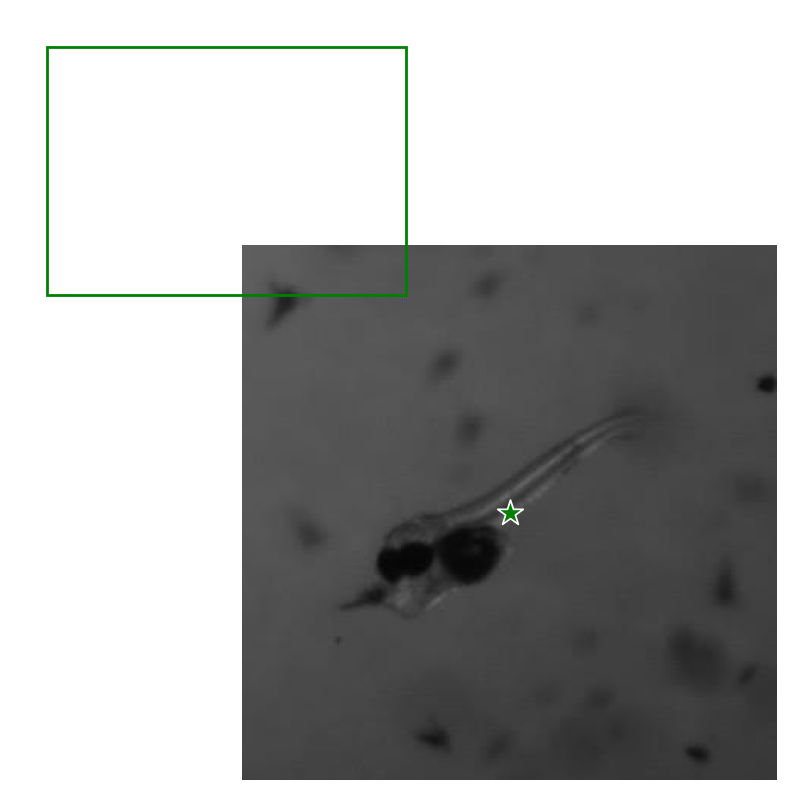

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(mask, plt.gca())
show_points(centroid2,np.array([1]),plt.gca())
show_box(box2, plt.gca())
plt.axis('off')
plt.show()

In [ ]:
    t = np.squeeze(trajs.cpu().numpy().astype(int))-50 # 50 is the padding added by pips
    t = t.clip(0,mask.shape[1]-1)
    fish_points = mask[t[int(t.shape[0]/2)-1,:,1],t[int(t.shape[0]/2)-1,:,0]]
    print(t[:,fish_points,:].shape)

(8, 15, 2)


In [ ]:
int(t.shape[0]/2)


4

In [ ]:

def run_chain(model, rgbs, xy0, sw):
    rgbs = rgbs.cuda().float() # B, S, C, H, W

    B, S, C, H, W = rgbs.shape
    #rgbs_ = rgbs.reshape(B*S, C, H, W)
    #H_, W_ = 360, 640
    #rgbs_ = F.interpolate(rgbs_, (H_, W_), mode='bilinear')
    #H, W = H_, W_
    #rgbs = rgbs_.reshape(B, S, C, H, W)
    N = xy0.shape[1]
    # try to pick a point on the dog, so we get an interesting trajectory
    # x = torch.randint(-10, 10, size=(1, N), device=torch.device('cuda')) + 468
    # y = torch.randint(-10, 10, size=(1, N), device=torch.device('cuda')) + 118
    # x = torch.ones((1, N), device=torch.device('cuda')) * 450.0
    # y = torch.ones((1, N), device=torch.device('cuda')) * 100.0
    #xy0 = torch.stack([x, y], dim=-1) # B, N, 2
    _, S, C, H, W = rgbs.shape

    trajs_e = torch.zeros((B, S, N, 2), dtype=torch.float32, device='cuda')
    for n in range(N):
        # print('working on keypoint %d/%d' % (n+1, N))
        cur_frame = 0
        done = False
        traj_e = torch.zeros((B, S, 2), dtype=torch.float32, device='cuda')
        traj_e[:,0] = xy0[:,n] # B, 1, 2  # set first position 
        feat_init = None
        while not done:
            end_frame = cur_frame + 8

            rgb_seq = rgbs[:,cur_frame:end_frame]
            S_local = rgb_seq.shape[1]
            rgb_seq = torch.cat([rgb_seq, rgb_seq[:,-1].unsqueeze(1).repeat(1,8-S_local,1,1,1)], dim=1)

            outs = model(traj_e[:,cur_frame].reshape(1, -1, 2), rgb_seq, iters=6, feat_init=feat_init, return_feat=True)
            preds = outs[0]
            vis = outs[2] # B, S, 1
            feat_init = outs[3]
            
            vis = torch.sigmoid(vis) # visibility confidence
            xys = preds[-1].reshape(1, 8, 2)
            traj_e[:,cur_frame:end_frame] = xys[:,:S_local]

            found_skip = False
            thr = 0.9
            si_last = 8-1 # last frame we are willing to take
            si_earliest = 1 # earliest frame we are willing to take
            si = si_last
            while not found_skip:
                if vis[0,si] > thr:
                    found_skip = True
                else:
                    si -= 1
                if si == si_earliest:
                    # print('decreasing thresh')
                    thr -= 0.02
                    si = si_last
            # print('found skip at frame %d, where we have' % si, vis[0,si].detach().item())

            cur_frame = cur_frame + si

            if cur_frame >= S:
                done = True
        trajs_e[:,:,n] = traj_e
    
    pad = 50
    rgbs = F.pad(rgbs.reshape(B*S, 3, H, W), (pad, pad, pad, pad), 'constant', 0).reshape(B, S, 3, H+pad*2, W+pad*2)
    trajs_e = trajs_e + pad

    prep_rgbs = utils.improc.preprocess_color(rgbs)
    gray_rgbs = torch.mean(prep_rgbs, dim=2, keepdim=True).repeat(1, 1, 3, 1, 1)
    
    if sw is not None and sw.save_this:
        linewidth = 2

        for n in range(N):
            # print('visualizing kp %d' % n)
            kp_vis = sw.summ_traj2ds_on_rgbs('video_%d/kp_%d_trajs_e_on_rgbs' % (sw.global_step, n), trajs_e[0:1,:,n:n+1], gray_rgbs[0:1,:S], cmap='spring', linewidth=linewidth)

            # write to disk, in case that's more convenient
            kp_list = list(kp_vis.unbind(1))
            kp_list = [kp[0].permute(1,2,0).cpu().numpy() for kp in kp_list]
            kp_list = [Image.fromarray(kp) for kp in kp_list]
            out_fn = './chain_out_%d.gif' % sw.global_step
            kp_list[0].save(out_fn, save_all=True, append_images=kp_list[1:])
            print('saved %s' % out_fn)
            
        sw.summ_traj2ds_on_rgb('outputs/trajs_e_on_rgb', trajs_e[0:1], prep_rgbs[0:1,0], cmap='spring')
        sw.summ_traj2ds_on_rgb('outputs/trajs_e_on_rgb2', trajs_e[0:1], torch.mean(prep_rgbs[0:1], dim=1), cmap='spring')
        

    return trajs_e-pad


In [ ]:

# check two things: 
# 1. try to reason over a single 32 frame trajectory
# 2. Use the chain demo to connect 4 8-frame trajectories
vid,tens_vid = get_vid('/content/drive/MyDrive/PhD/Normalizing Flows/poc_dataset/train/clips/Seq1_05DPH_F07_midframe_17920_fish_0_coordinate_[144-532].avi',
              num_to_sample=32)
tens_vid.shape

torch.Size([1, 32, 3, 400, 400])

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PhD/Normalizing Flows/poc_dataset/train_clips.csv')

entry = df[df.clip_name=='Seq1_05DPH_F07_midframe_17920_fish_0_coordinate_[144-532].avi']

In [ ]:
xy_fish.shape

NameError: ignored

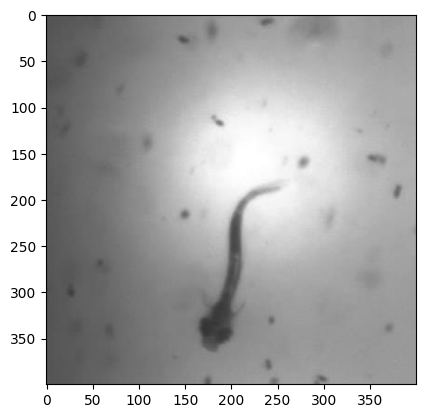

In [ ]:
plt.imshow(vid[0,...])

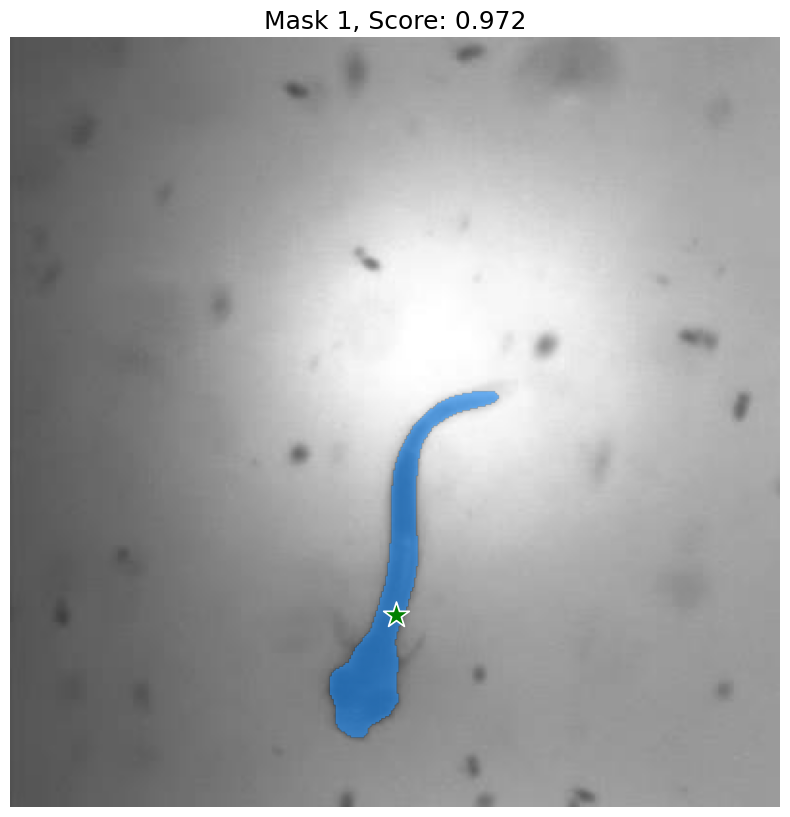

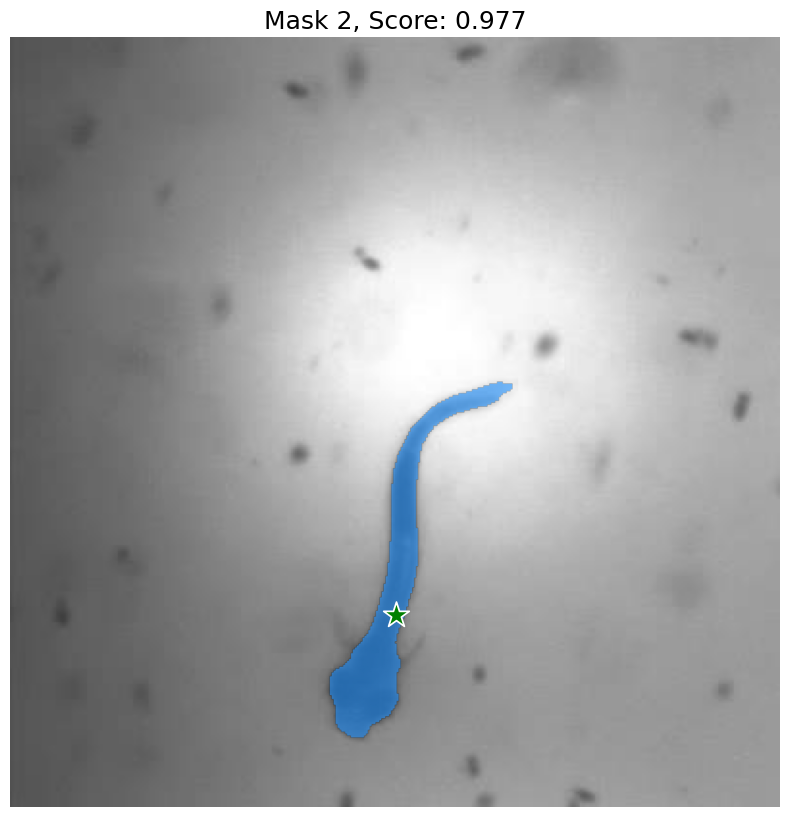

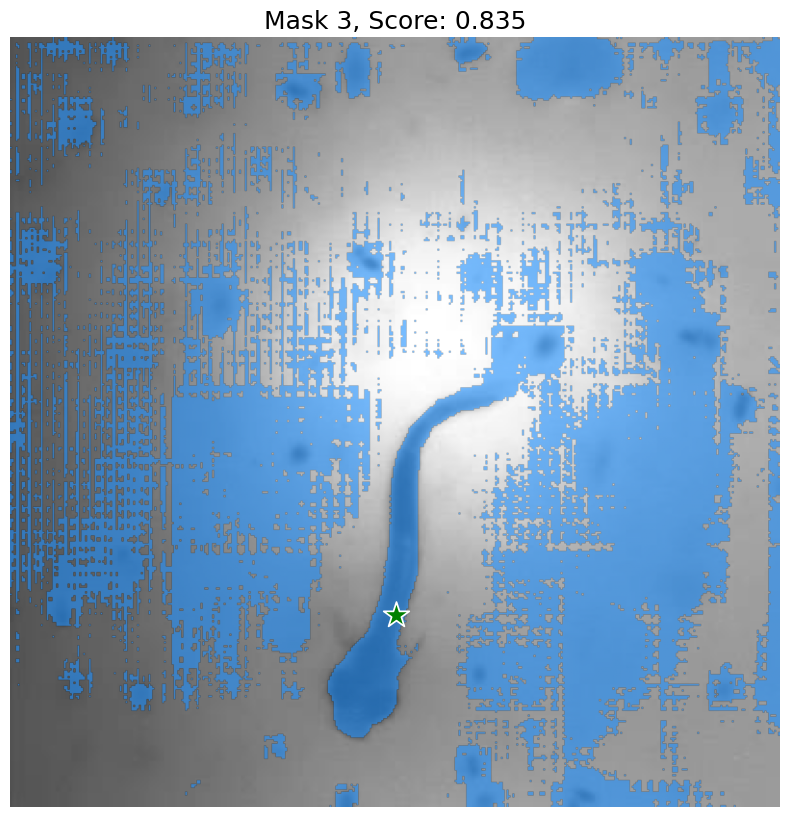

In [ ]:
# get mask manually
image = vid[0,...]
predictor.set_image(image)
input_point = np.array([[200, 300]])
input_label = np.array([1])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [ ]:
mask = np.squeeze(masks[1])

N=16**2
B, S, C, H, W = tens_vid.shape

N_ = np.sqrt(N).round().astype(np.int32)
grid_y, grid_x = utils.basic.meshgrid2d(B, N_, N_, stack=False, norm=False, device='cuda')

grid_y_ = 8 + grid_y.reshape(B, -1)/float(N_-1) * (H-16)
grid_x_ = 8 + grid_x.reshape(B, -1)/float(N_-1) * (W-16)
y = np.squeeze(grid_y_.cpu().numpy().astype(int))
x = np.squeeze(grid_x_.cpu().numpy().astype(int))
print(grid_y.shape, grid_y_.shape)
xy = torch.stack([grid_x_, grid_y_], dim=-1)
print(xy.shape)
fish_points = mask[y,x]
xy_fish = xy[:,fish_points,...]
xy_fish

torch.Size([1, 16, 16]) torch.Size([1, 256])
torch.Size([1, 256, 2])


tensor([[[238.4000, 187.2000],
         [212.8000, 212.8000],
         [187.2000, 315.2000],
         [187.2000, 340.8000]]], device='cuda:0')

In [ ]:
cd /content/drive/MyDrive/PhD/pips sample

/content/drive/MyDrive/PhD/pips sample


In [ ]:
trajs = run_chain(model.cuda(), tens_vid, xy_fish, sw_t)

OutOfMemoryError: ignored

In [ ]:
rgbs,trajs= run_model_custom(model.cuda(),tens_vid[:,0:8,...],N)
t = np.squeeze(trajs.cpu().numpy().astype(int)).clip(0,H-1)
fish_points = mask[t[0,:,1],t[0,:,0]]
print(t[:,fish_points,:].shape)
trajs[:,:,fish_points,...]


trajs_e (float32) min = -30.44, mean = 188.23, max = 397.23 torch.Size([1, 8, 256, 2])
(8, 105, 2)


tensor([[[[109.2000,  58.0000],
          [134.8000,  58.0000],
          [339.6000,  58.0000],
          ...,
          [288.4000, 442.0000],
          [314.0000, 442.0000],
          [339.6000, 442.0000]],

         [[106.9612,  55.0081],
          [132.1418,  54.8948],
          [339.7026,  57.5786],
          ...,
          [285.7622, 438.3546],
          [310.8710, 442.2315],
          [335.2682, 439.2156]],

         [[106.9756,  48.4303],
          [132.8603,  51.4605],
          [339.7554,  57.8226],
          ...,
          [280.9378, 430.2402],
          [305.3696, 440.1693],
          [329.5770, 432.3261]],

         ...,

         [[100.1412,  41.7682],
          [130.1971,  46.5281],
          [340.1702,  59.0737],
          ...,
          [268.6968, 410.5390],
          [291.8633, 431.8962],
          [316.9677, 414.4785]],

         [[ 97.7320,  32.7804],
          [135.1971,  47.3814],
          [340.3446,  57.9319],
          ...,
          [263.9639, 403.6016],
      

In [ ]:
#use available bbox
bbox = np.array(ast.literal_eval(entry.bboxs.item()))
centroid = np.array(ast.literal_eval(entry.centroid.item()))
x_offset,_,y_offset,_ = get_clip_bounds([1080,1920], centroid, round(vid.shape[-2]/2))
bbox = bbox -[x_offset,y_offset,x_offset,y_offset]
centroid = np.array([centroid])-[x_offset,y_offset]
 

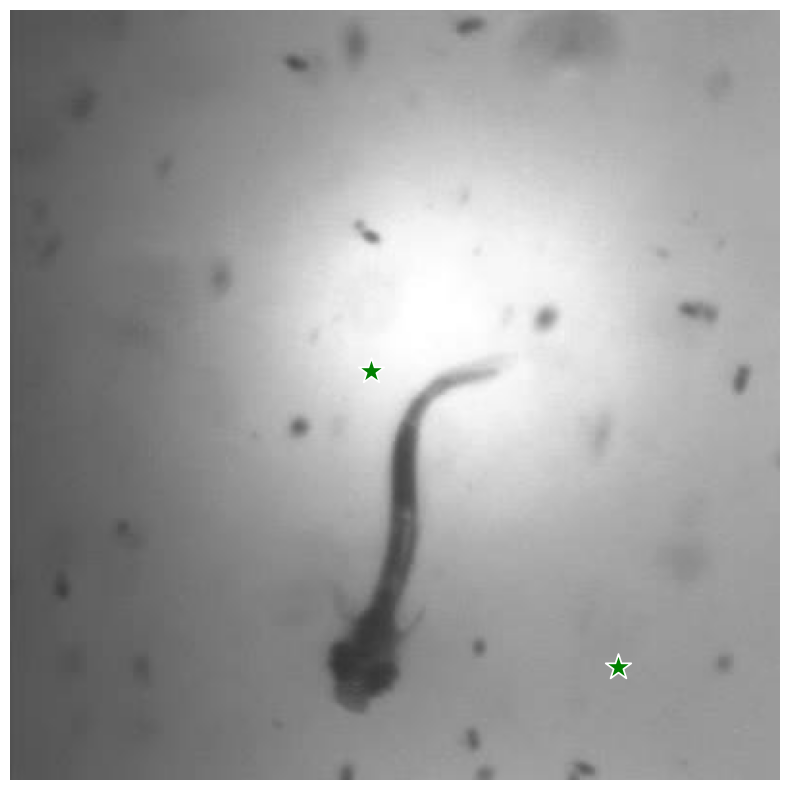

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(vid[0,...])
#show_mask(mask, plt.gca())
show_points(xy_fish.cpu().numpy(),np.array([1]),plt.gca())
#show_box(bbox, plt.gca())
plt.axis('off')
plt.show()

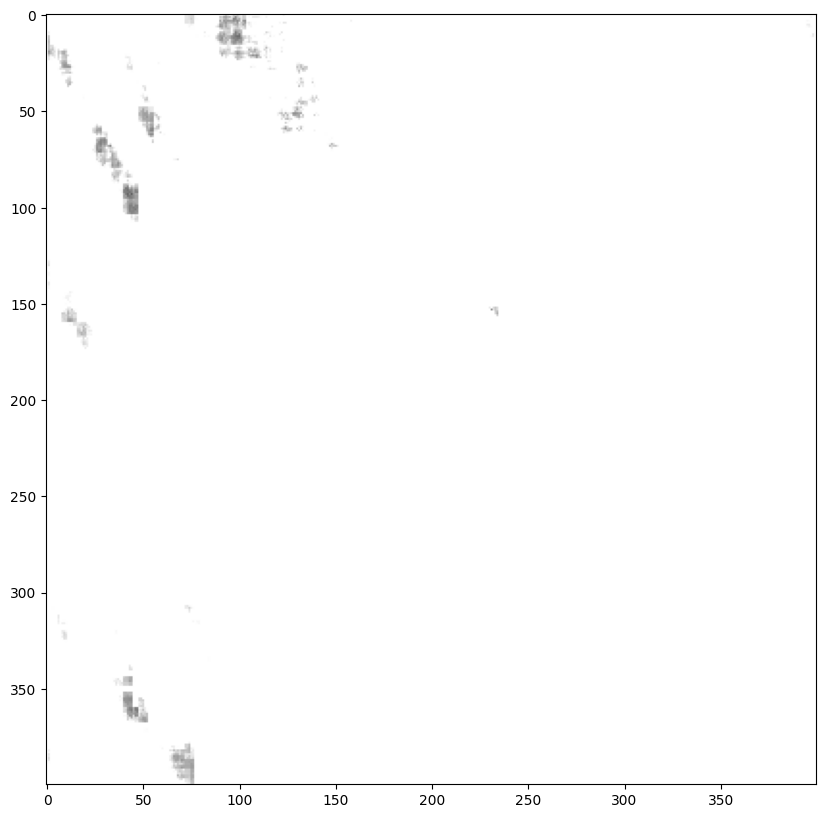

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(vid.var(axis=0))